In [ ]:
# !wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
# !dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
# !apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
# !apt update -q
# !apt install cuda gcc-6 g++-6 -y -q
# !ln -s /usr/bin/gcc-6 /usr/local/cuda/bin/gcc
# !ln -s /usr/bin/g++-6 /usr/local/cuda/bin/g++

In [ ]:
# !curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.3-linux-x86_64.tar.gz" -o julia.tar.gz
# !tar -xzf julia.tar.gz -C /usr --strip-components 1
# !rm -rf julia.tar.gz*
# !julia -e 'using Pkg; pkg"add IJulia; precompile"'

# Experiment on Orthogonal Learning

In [1]:
# import Pkg

# Pkg.add("CovarianceMatrices")

In [1]:
using Distributions
using DataFrames
using CSV
using Tables
using GLM
using CovarianceMatrices

using Gadfly

In [2]:
using Random
Random.seed!(1234)

TaskLocalRNG()

In [3]:
#importamos hdmjl
include("../Julia_Notebooks/hdmjl/hdmjl.jl")

In [4]:
#=
#codigo individual
/*
n = 10000
p = 100
beta = 1/(1:p).^2
gamma = 1/(1:p).^2

X = rand(Normal(0,1),n,p)
D = X * transpose(gamma) + (rand(Normal(0,1),n,1)/4)
Y = D + X * transpose(beta) + rand(Normal(0,1),n,1);

X1 = hcat(D,X)
model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
coef1 = rlasso(model1)["coefficients"][3:102,2]
SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .== 0 )

if (sum(coef1[SX_IDs,:])==0) 
    Y1 = DataFrame(hcat(Y,D),["Y","D"])
    print(coef(lm(@formula(Y ~ D), Y1))[2]) #enlace con Naive
end

if (sum(coef1[SX_IDs,:])>0) 
    Y2 = DataFrame(hcat(Y,D,X[:,SX_IDs]),["Y","D","Xi"])
    print(coef(lm(@formula(Y ~ D + Xi), Y2))[2]) #enlace con Naive
end

model2 =rlasso_arg( X, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
model3 =rlasso_arg( X, D ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true );

resY = rlasso(model2)["residuals"]
resD = rlasso(model3)["residuals"]
Y3=DataFrame(hcat(resY,resD),["resY","resD"])
coef(lm(@formula(resY ~ resD), Y3))[2] #enlace orthogonal
=#


In [ ]:
B = 50
Naive = zeros(B)
Orthogonal = zeros(B)

for i in 1:B
    n = 10000
    p = 100
    beta = 1/(1:p).^2
    gamma = 1/(1:p).^2

    X = rand(Normal(0,1),n,p)
    D = X * transpose(gamma) + (rand(Normal(0,1),n,1)/4)
    Y = 5*D + X * transpose(beta) + rand(Normal(0,1),n,1)
    
    X = DataFrame(X, :auto)
    D = DataFrame(D, ["D"])
    X1 = hcat(D,X)

    Y = DataFrame(Y, ["Y"])
    
    model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, false, Inf, true )
    coef1 = rlasso(model1)["coefficients"][3:102,2]
    SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .!= 0 )

    if (sum(coef1[SX_IDs,:])==0) 
        Y1 = hcat(Y,D)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] -5
    end

    if (sum(coef1[SX_IDs,:])>0) 
        Xi = DataFrame(X[:,SX_IDs])
        Y2 = hcat(Y,D,Xi)
        Naive[i] = coef(lm(@formula(Y ~ D + Xi), Y2))[2] - 5
    end

    model2 =rlasso_arg( X, Y ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    model3 =rlasso_arg( X, D ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

    resY = rlasso(model2)["residuals"]
    resD = rlasso(model3)["residuals"]
    Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i]= coef(lm(@formula(resY ~ resD), Y3))[2] -5

end


results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 50 trials")
))

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 50 trials")
))

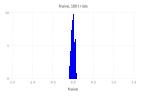

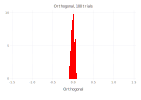

In [82]:
B = 100
Naive = zeros(B)
Orthogonal = zeros(B)

for i in 1:B
    n = 10000
    p = 100
    beta = 1/(1:p).^2
    gamma = 1/(1:p).^2

    X = rand(Normal(0,1),n,p)
    D = X * transpose(gamma) + (rand(Normal(0,1),n,1)/4)
    Y = 5*D + X * transpose(beta) + rand(Normal(0,1),n,1);

    X = DataFrame(X, :auto)
    D = DataFrame(D, ["D"])
    X1 = hcat(D,X)
    Y = DataFrame(Y, ["Y"])
    
    model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    coef1 = rlasso(model1)["coefficients"][3:102,2]
    SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .!= 0 )

    if (sum(coef1[SX_IDs,:])==0) 
        Y1 = hcat(Y,D)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 5
    end

    if (sum(coef1[SX_IDs,:])>0) 
        Xi = DataFrame(X[:,SX_IDs], ["Xi"])
        Y2 = hcat(Y,D,Xi)
        Naive[i] = coef(lm(@formula(Y ~ D + Xi), Y2))[2]-5
    end

    model2 =rlasso_arg( X, Y ,nothing, true, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    model3 =rlasso_arg( X, D ,nothing, true, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

    resY = rlasso(model2)["residuals"]
    resD = rlasso(model3)["residuals"]
    Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i]= coef(lm(@formula(resY ~ resD), Y3))[2]-5

end


results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 100 trials")
))

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 100 trials")
))

In [86]:
results

,Naive,Orthogonal
,Float64,Float64
1,-0.0127223,-0.0127223
2,0.0829293,0.0829293
3,-0.0107917,-0.0107917
4,-0.0119867,-0.0119867
5,-0.0699845,-0.0699845
6,-0.0505134,-0.0505134
7,-0.0125616,-0.0125616
8,0.0367595,0.0367595
9,0.0153058,0.0153058


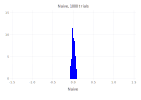

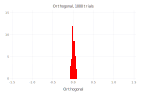

In [83]:
# B = 1000
Naive = zeros(B)
Orthogonal = zeros(B)

for i in 1:B
    n = 10000
    p = 100
    beta = 1/(1:p).^2
    gamma = 1/(1:p).^2

    X = rand(Normal(0,1),n,p)
    D = X * transpose(gamma) + (rand(Normal(0,1),n,1)/4)
    Y = 5*D + X * transpose(beta) + rand(Normal(0,1),n,1);

    X = DataFrame(X, :auto)
    D = DataFrame(D, ["D"])
    X1 = hcat(D,X)
    Y = DataFrame(Y, ["Y"])
    
    model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    coef1 = rlasso(model1)["coefficients"][3:102,2]
    SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .!= 0 )

    if (sum(coef1[SX_IDs,:])==0) 
        Y1 = hcat(Y,D)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 5
    end

    if (sum(coef1[SX_IDs,:])>0) 
        Xi = DataFrame(X[:,SX_IDs], ["Xi"])
        Y2 = hcat(Y,D,Xi)
        Naive[i] = coef(lm(@formula(Y ~ D + Xi), Y2))[2] - 5
    end

    model2 =rlasso_arg( X, Y ,nothing, true, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    model3 =rlasso_arg( X, D ,nothing, true, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

    resY = rlasso(model2)["residuals"]
    resD = rlasso(model3)["residuals"]
    Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i]= coef(lm(@formula(resY ~ resD), Y3))[2] - 5

end


results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 1000 trials")
))

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 1000 trials")
))